In [10]:
# PDE: -u_xx - u_yy = f(x, y)  on  [0,1]^2
# BCs:
#   u(x, 0) = 0
#   n·∇u = 0  at x=0 and x=1   (Neumann)
#   u(x, 1) = cos(π x)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sla

In [12]:
def laplace_finite_difference(nx, ny):

    # Create cell-centered grid
    x1d, hx = np.linspace(0, 1, nx, endpoint=False, retstep=True)
    y1d, hy = np.linspace(0, 1, ny, endpoint=False, retstep=True)
    x1d += hx / 2
    y1d += hy / 2

    # Create 2D meshgrid
    x, y = np.meshgrid(x1d, y1d)

    # Compute and print mesh statistics
    total_points = x.size
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    print("Mesh Statistics:")
    print(f"  Total points: {total_points}")
    print(f"  x range: {x_min:.3f} to {x_max:.3f} (spacing hx={hx:.5f})")
    print(f"  y range: {y_min:.3f} to {y_max:.3f} (spacing hy={hy:.5f})")

    N = ny * nx

    alpha = 1 / hx**2
    beta  = 1 / hy**2

    def f_func(x, y):
        return 0.0

    A = sp.lil_matrix((N, N))
    b = np.zeros(N)

    # Fill matrix A and vector b for interior nodes (excluding y-boundaries)
    for i in range(1, ny - 1):
        for j in range(nx):
            k = i * nx + j
            b[k] = f_func(x1d[j], y1d[i])

            # --- x-direction discretization (Neumann BC at x=0 and x=nx-1) ---
            if j == 0:
                # Left boundary Neumann condition (ghost point approach)
                A[k, k]     += 2 * alpha
                A[k, k + 1] += -2 * alpha
            elif j == nx - 1:
                # Right boundary Neumann condition
                A[k, k]     += 2 * alpha
                A[k, k - 1] += -2 * alpha
            else:
                # Interior x nodes
                A[k, k - 1] += -alpha
                A[k, k]     += 2 * alpha
                A[k, k + 1] += -alpha

            # --- y-direction discretization ---
            # Lower neighbor: if i > 1, then use interior discretization,
            # otherwise (i==1) the lower neighbor is the bottom boundary (u=0)
            if i > 1:
                A[k, k - nx] += -beta

            # Upper neighbor: if i==ny-2, then the upper neighbor is the top boundary
            if i == ny - 2:
                b[k] += beta * np.sin(np.pi * x1d[j])
            else:
                A[k, k + nx] += -beta

            # Central term for y-direction
            A[k, k] += 2 * beta


    # Apply Dirichlet boundary conditions in the y-direction after the loop, vectorized
    bottom = np.arange(nx)                        # i = 0 boundary indices
    top = np.arange((ny - 1) * nx, ny * nx)         # i = ny-1 boundary indices

    # Bottom boundary: u(x, 0) = 0
    A[bottom, :] = 0
    A[bottom, bottom] = 1.0
    b[bottom] = 0.0

    # Top boundary: u(x, 1) = sin(pi*x)
    A[top, :] = 0
    A[top, top] = 1.0
    b[top] = np.sin(np.pi * x1d)

    u_vec = sla.spsolve(A.tocsr(), b)
    u = u_vec.reshape((ny, nx))

    # fig, ax = plt.subplots(figsize=(6, 5))
    # c = ax.pcolormesh(x, y, u, shading='auto', cmap='plasma')
    # ax.set_aspect('equal')
    # ax.set_axis_off()
    # cb = fig.colorbar(c, ax=ax)
    # cb.set_label("u")
    # plt.show()


Mesh Statistics:
  Total points: 40000
  x range: 0.003 to 0.997 (spacing hx=0.00500)
  y range: 0.003 to 0.997 (spacing hy=0.00500)


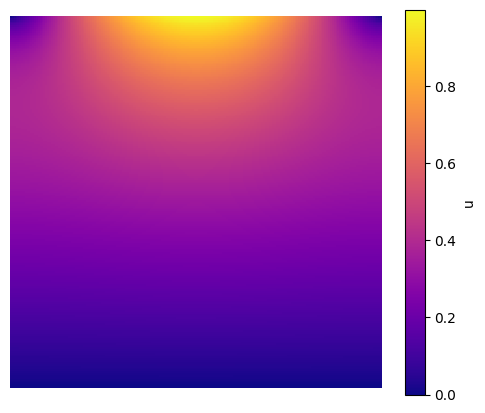

In [13]:
laplace_finite_difference(nx = 200, ny = 200)